In [31]:
##Preable
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pickle

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

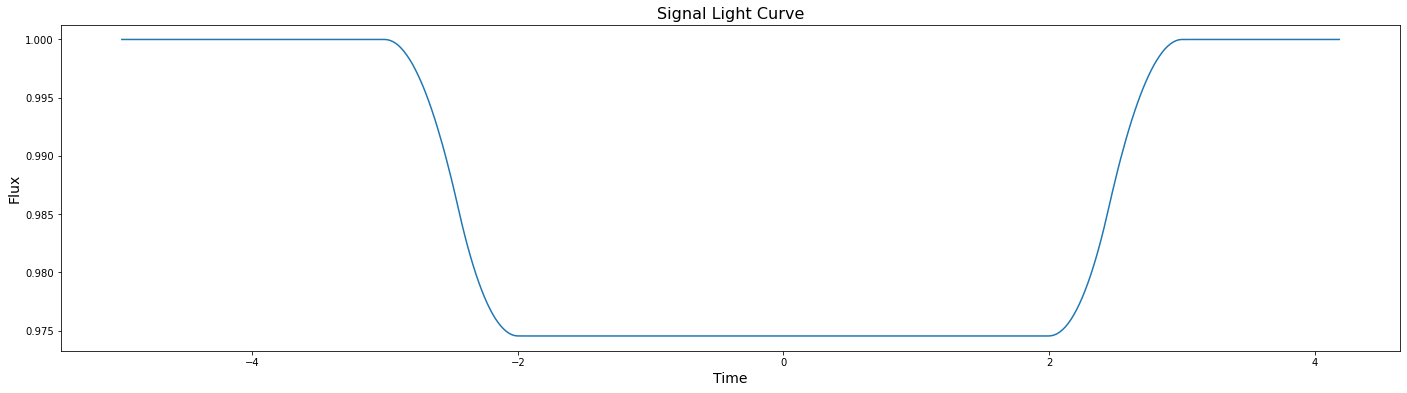

In [32]:
overlapTimes, planetLC = np.loadtxt("Signals/test1.txt", unpack = True)

fig, ax = plt.subplots(1,1,figsize=(24,6))##Plotting for good measure
ax.plot(overlapTimes,planetLC)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Flux",fontsize=14)
plt.title(r"Signal Light Curve",fontsize=16)
plt.show()

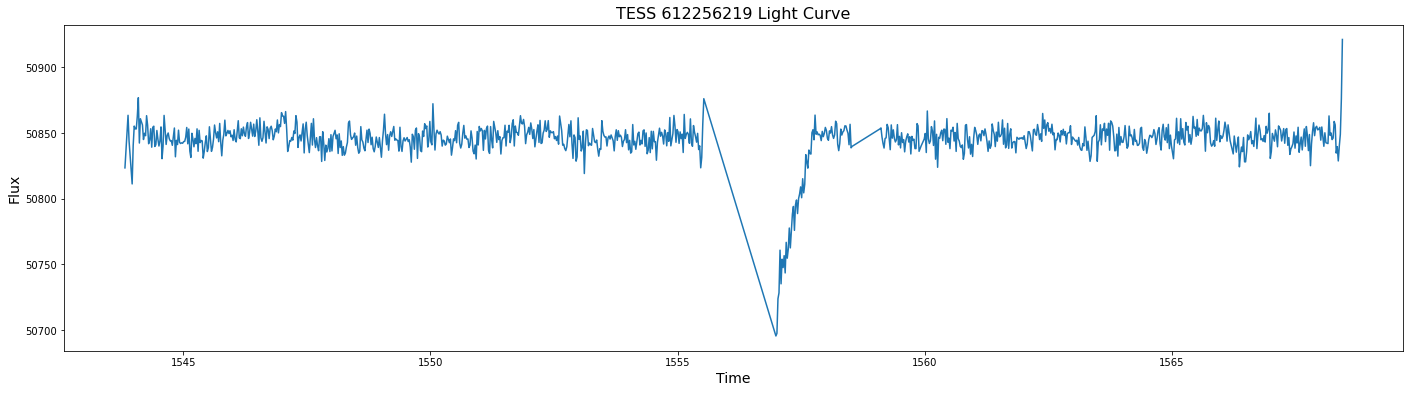

In [33]:
fp = open("./TESSCurves/tesslc_364539361.pkl","rb") ##Loading the file
data = pickle.load(fp)
fp.close()

q = data[11]==0 #Extracting the data we want, can only keep high quality data
times = data[6][q]
lc = data[8][q]


fig, ax = plt.subplots(1,1,figsize=(24,6))##Plotting for good measure
ax.plot(times,lc)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Flux",fontsize=14)
plt.title(r"TESS 612256219 Light Curve",fontsize=16)
plt.show()

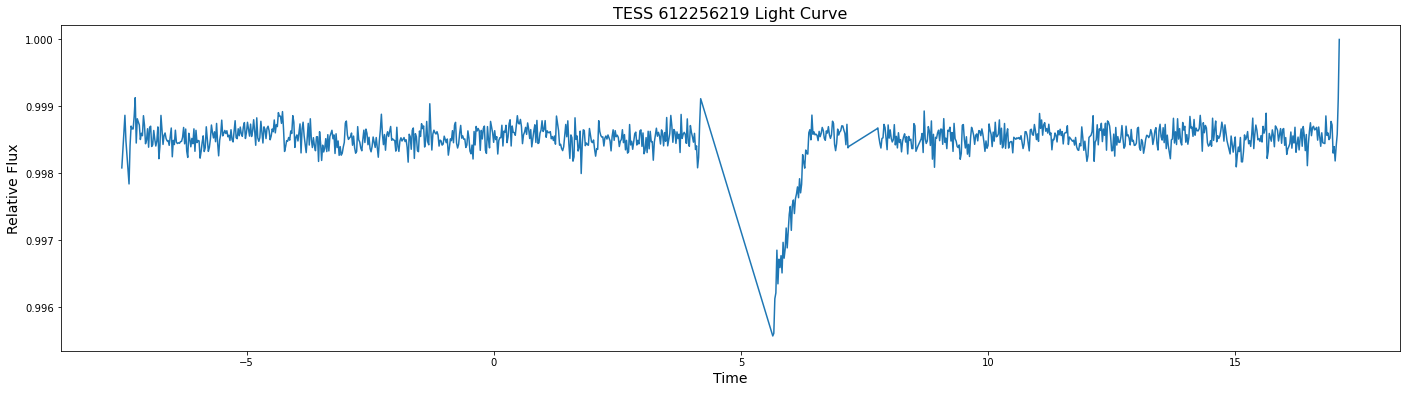

In [34]:
midTime = np.percentile(times,33) ##Set the 0 point at 1/3. Eight Bit Transit centers light curves at 0 so put this where you want to center the transit
##Tess light curves seem to have a 2 day gap near the center
times = times - midTime


maxlc = max(lc)##Normalize Light Curve
normLc = lc/maxlc

fig, ax = plt.subplots(1,1,figsize=(24,6))
ax.plot(times,normLc)
plt.xlabel("Time",fontsize=14)
plt.ylabel("Relative Flux",fontsize=14)
plt.title(r"TESS 612256219 Light Curve",fontsize=16)
plt.show()

In [35]:
def extendLC(LC, overlapTimes, times): 
    ##Extends a light curve from Eight Bit Transit by adding full flux to the ends for the desired length
    ##Assumption: Maximum flux value is 1
    ##Assumption: Light curve is at maximum value at the start and end
    extendedLC = np.ones(len(times))##Start with full flux curve
    overlapIndex = 0
    for i in range(len(times)):##Iterate over the desired time array
        if times[i] == overlapTimes[overlapIndex]: ##When the desired time has caught up to the light curve from ebt, use the ebt values
            if overlapIndex < len(overlapTimes) - 2:##Only do this to the end of the ebt light curve
                overlapIndex += 1
                extendedLC[i]  = LC[overlapIndex]
        
    
    return extendedLC, times

In [36]:
def sumLightCurves(trueLC, genLC): 
    ##Sums a true light curve and a generated lightcurve
    ##Assumptions: 1 is the maximal value for both light curves
    ##Assumption: The sum of both light curves is greater than one at every point, this can be satisfied by using a non-variable true light curve and leaving >1% as the minimum in the generated curve
    if len(trueLC) - len(genLC) != 0:
        raise Exception("Light Curves must be the same size: " + str(len(trueLC))+ "," + str(len(genLC)))
    sumLC = trueLC + genLC - 1
    ##Generated Light curve has no noise, subtracting 1 from this light curve gives reduction due to transit
    ##Preserves noise in original light curve (average would half it)
    ##Assumes min value in both light curves >0.5, anything violating this assumption is grounds for further investigation in itself 
    return sumLC

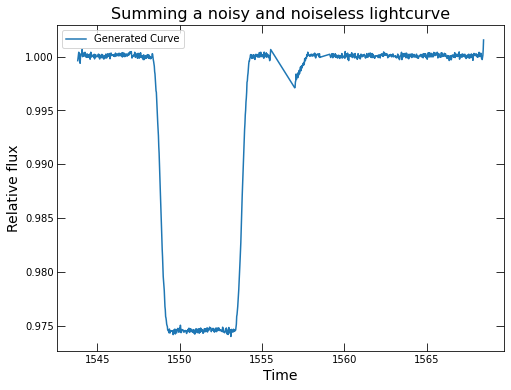

In [37]:
longTransitLC, overlapTimes = extendLC(planetLC, overlapTimes, times)##Extending the light curve to match the TESS curve
sumLC = sumLightCurves(normLc, longTransitLC)##Summing and normalizing lightcurves
medLC = np.median(sumLC)
sumLC = sumLC/medLC
overlapTimes = overlapTimes + midTime ##Resetting time array to original values

fig, ax = plt.subplots(1,1,figsize=(8,6))##PLotting
ax.plot(overlapTimes,sumLC,label = "Generated Curve", ls = '-')
ax.legend()
plt.xlabel("Time",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"Summing a noisy and noiseless lightcurve",fontsize=16)

ax.tick_params(direction = "in", which = "major", length = 8, top = True, right = True)
ax.tick_params(direction = "in", which = "minor", length = 4, top = True, right = True)


plt.show()